# Intervention Analysis with Python

#### Intervention

"An intervention is a one-off event which has an impact on the forecast variable. We can model the effect of the intervention using a special case of dynamic regression model. The impact may be instanteneous or it may be spread over a period of time. However, the intervention is assumed to occur at one time period only."

-Forecasting: Methods And Applications, S.Makridakis et al., p.418-9

In our case we will look at time series data which we will model using scikit-learn. Before that, let's start with the usual imports, add some styling to the graphs, and specify that our plots should appear inline.

In [1]:
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
mpl.style.use("bmh")
%matplotlib inline

### Exploratory data analysis and pre-processing

Load the dataset, check the dataframe, and draw some plots. Reading notes about the data is equally -if not more- important. Here, our data show: "the daily scores achieved by a schizophrenic patient on a test of perceptual speed. The patient began receiving a powerful tranquilizer (chlorpromazine) on the sixty-first day and continued receving the drug for the rest of the sample period."

In [2]:
df = pd.read_excel("PerceptualSpeed.xlsx")

In [3]:
df.head()

,Day,Perceptual_Speed
0,1,55
1,2,56
2,3,48
3,4,46
4,5,59


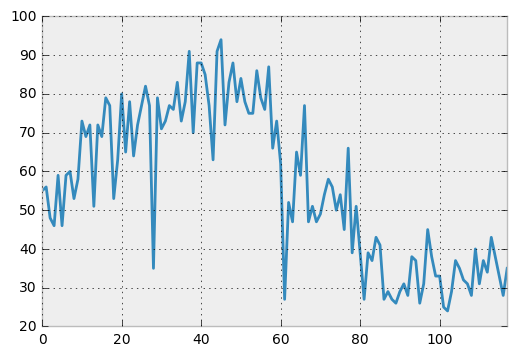

In [4]:
df["Perceptual_Speed"].plot();

Our data seem to have significant fluctuations so some smoothing is in order. I chose a simple moving average of order 3 (hereby denoted as MA(3)). The reason I decided to set center to False is because I'd rather discard the first two observations than the first and last.

In [5]:
df['Smoothed'] = df['Perceptual_Speed'].rolling(3, center=False).mean()

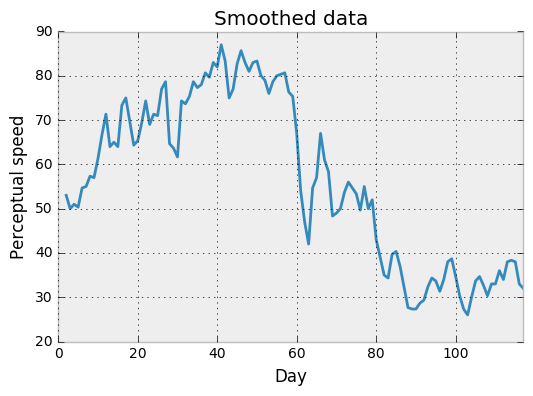

In [6]:
df.Smoothed.plot()
plt.title('Smoothed data')
plt.ylabel('Perceptual speed')
plt.xlabel('Day'); # semicolon to hide mpl's output text

Modelling an intervention can be done with a dummy variable to show the effects of the intervention. An intervention can affect our variable in four main ways:<br><br>

<img src="interventions.jpg" width="500">
<center><b>Figure 8-15: Four simple intervention variables.</b><br><center>-Forecasting: Methods And Applications, S.Makridakis et al., p.420<br><br>

Here, using `.apply` with a lambda function, I created two dummies (drug effect and persistent/delayed drug effect) as two "step interventions", but one could also use just one dummy representing a "delayed/decayed intervention" (using a different lambda, say log(x) or 1/x). I (arbitrarily) chose day 80 as the cutoff for the second intervention simply because around that day we can notice the second sharp drop in perceptual speed.

In [7]:
df['drug'] = df['Day'].apply(lambda x: 0 if x<60 else 1)
df['drug_persistent'] = df['Day'].apply(lambda x: 0 if x<80 else 1)

Let's review what our dataframe looks like.

In [8]:
df.head()

,Day,Perceptual_Speed,Smoothed,drug,drug_persistent
0,1,55,NaN,0,0
1,2,56,NaN,0,0
2,3,48,53.0,0,0
3,4,46,50.0,0,0
4,5,59,51.0,0,0


In [9]:
df.tail()

,Day,Perceptual_Speed,Smoothed,drug,drug_persistent
113,114,43,38.000000,1,1
114,115,38,38.333333,1,1
115,116,33,38.000000,1,1
116,117,28,33.000000,1,1
117,118,35,32.000000,1,1


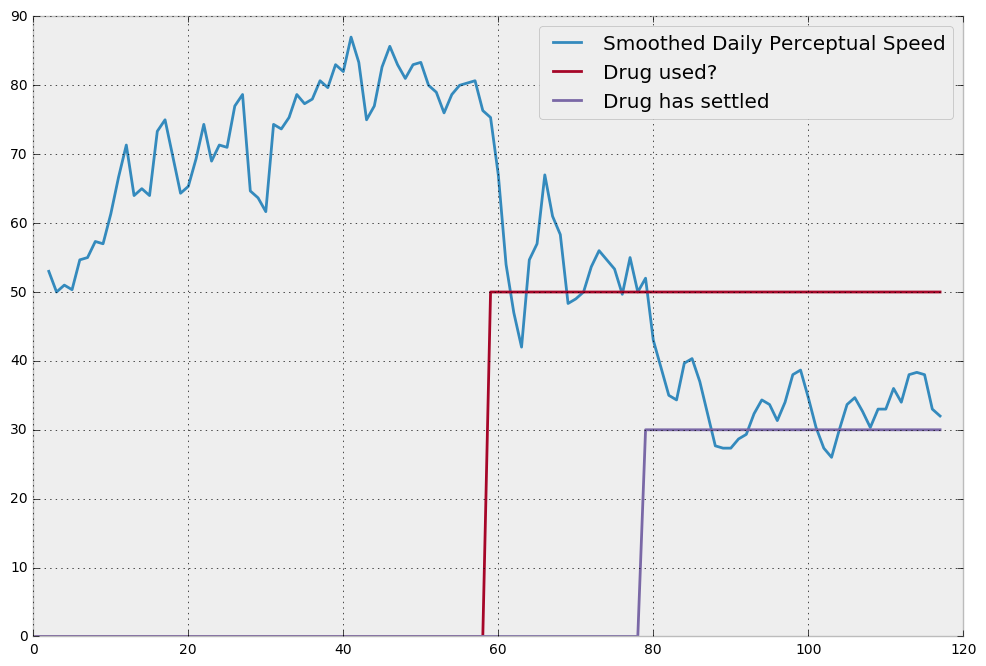

In [10]:
plt.figure(figsize=(12,8))
plt.plot(df['Smoothed'],label="Smoothed Daily Perceptual Speed")
plt.plot(df.drug.apply(lambda x: x*50),label="Drug used?")
plt.plot(df.drug_persistent.apply(lambda x: x*30),label="Drug has settled")
plt.legend(fontsize="x-large");

### Modelling

Three models, each accounting for some additional complexity (i.e. variable). Since I'm using sklearn's version 0.18 I cannot use train_test_split because it shuffles the data (but v0.19 gives you that choice). Thus, the first 100 observations will be the training set and the remaining 15 will be the test set. Having modeled the second intervention on day 80 if I didn't allow for enough observations to be included in the training set then the model's performance would suffer (albeit slightly).

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
model1 = LinearRegression()
model2 = LinearRegression()
model3 = LinearRegression()

In essence, the regressions below will be of the form: Υ[t] ~ ( Υ[t-1] + Υ[t-2] + Υ[t-3] ) / 3

In [13]:
df_clean = df.dropna() # drop rows with missing values 

y = df_clean['Perceptual_Speed'].values[1:]
x1 = df_clean["Smoothed"].values[:-1].reshape(-1, 1) # to avoid an error
x2 = df_clean[['Smoothed','drug']][:-1]
x3 = df_clean[['Smoothed','drug','drug_persistent']][:-1]

y_train, y_test = y[:100], y[100:]
x_train1, x_test1,  = x1[:100], x1[100:]
x_train2, x_test2 = x2[:100], x2[100:]
x_train3, x_test3 = x3[:100], x3[100:]

In [14]:
model1.fit(x_train1, y_train)
model2.fit(x_train2, y_train)
model3.fit(x_train3, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Model evaluation: test set

R² is probably the most widely used statistic to measure model perfomance but since we are dealing with forecasts another statistic is more appropriate. Theil's U-statistic measures how our model performs, prediction-wise. It works by comparing the percentage change of our prediction with the percentage change of the dependent variable. One should read it as follows:

- U = 1: the naive method (predicting that the value of y won't change) is as good as our model.
- U < 1: our model is better than the naive method. Exact forecasts (0 error) are awarded a U=0.
- U > 1: our model performs worse than the naive method.

In [15]:
def TheilsU(x, y, model):
    preds = model.predict(x)
    num = []
    den = []
    for i in range(1, len(preds)):
        num.append((preds[i] - y[i] / y[i-1])**2)
        den.append((y[i] - y[i-1]/y[i-1])**2)
        
    u = (sum(num)/sum(den)) ** 0.5
    
    return u

The first model (reminder: a linear regression using only the MA(3) as the predictor) performs terribly, having a U-statistic greater than 1. 

In [16]:
print("Theil's U =", TheilsU(x_test1, y_test, model1))
print("R² =", model1.score(x_test1, y_test))

Theil's U = 1.0107945484
R² = -0.764014093777


And the second model does a similarly bad job with a slightly worse U. We are better off if we forecast no change, aka the previous value (y[t-1]).

In [17]:
print("Theil's U =", TheilsU(x_test2, y_test, model2))
print("R² =", model2.score(x_test2, y_test))

Theil's U = 1.01414087492
R² = -0.435443599812


However, the third model seems to work comparably better. The R² is almost equal to the second model but Theil's U is at 0.9286 indicating some progress.

In [18]:
print("Theil's U =", TheilsU(x_test3, y_test, model3))
print("R² =", model3.score(x_test3, y_test))

Theil's U = 0.926507462581
R² = -0.449899186891


Measuring the R² and U on the whole dataset is not useful because we would be evaluation the models' predictions on data they were trained on (thus increasing R² and overfitting). We can, however, visualize those predictions, showing where the cutoff is, so that we can have a clear view of performance.

In [19]:
preds1 = model1.predict(x1)
preds2 = model2.predict(x2)
preds3 = model3.predict(x3)

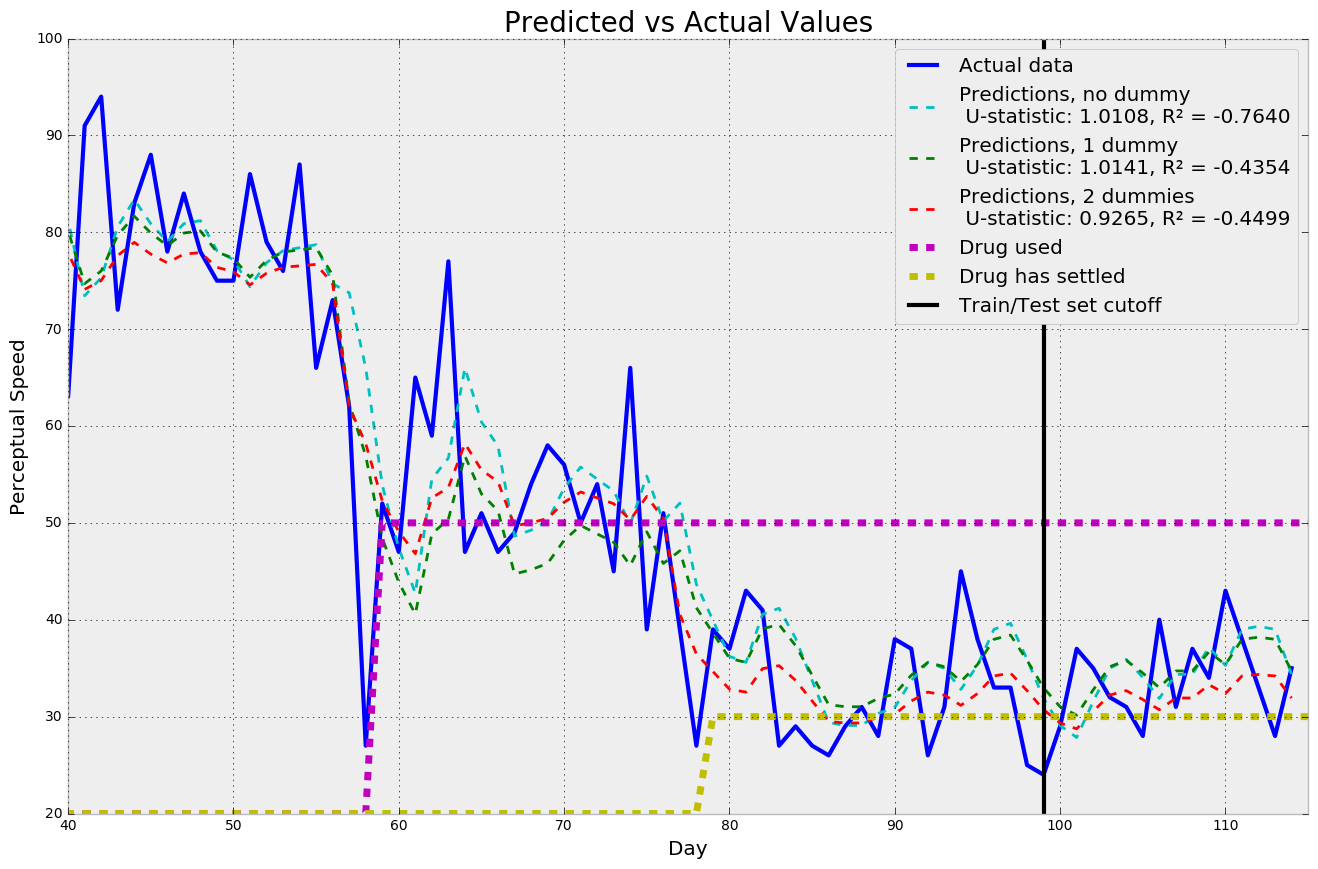

In [20]:
plt.figure(figsize=(16,10))

plt.plot(y, "b-", lw=3, label="Actual data");
plt.title("Predicted vs Actual Values", fontdict={'fontsize':20})
plt.ylabel("Perceptual Speed", fontsize='x-large')
plt.xlabel("Day", fontsize='x-large')


for (pred, col, dum, x, model) in zip([preds1, preds2, preds3], ["c--", "g--", "r--"], 
                    ['no dummy', '1 dummy', '2 dummies'], [x_test1, x_test2, x_test3], [model1, model2, model3]):
    
    plt.plot(pred, col, label="Predictions, {}\n U-statistic: {:.4f}, R² = {:.4f}".format(dum,
                                                        TheilsU(x, y_test, model), model.score(x, y_test)))


plt.ylim(20,100)
plt.xlim(40,115)

plt.plot(df.drug.apply(lambda x: 20 + x*30), "m--", lw=5, label="Drug used")
plt.plot(df.drug_persistent.apply(lambda x: 20 + x*10), "y--", lw=5, label="Drug has settled")

plt.axvline(x=99, ymax=1, color='black', lw=3, label='Train/Test set cutoff')

plt.legend(fontsize='x-large', loc=1);

Before we are done we must perform one last check; validate that there is no remaining pattern left in the errors. This will tell us if there are improvements to be made. Subtracting the predictions of our model from the actual values should show no evident pattern. Indeed, the results seem centered around zero and the autocorrelations do not exceed the critical values.

In [21]:
from pandas.tools.plotting import autocorrelation_plot

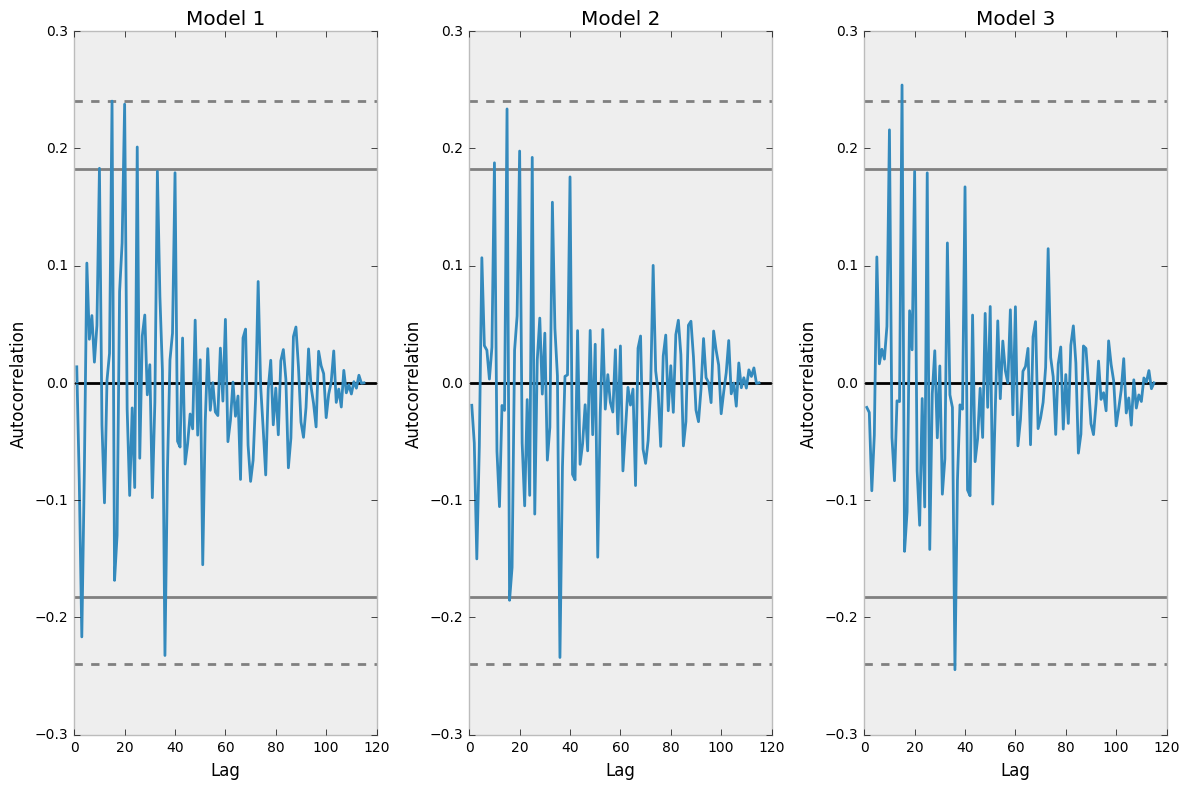

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,8))

for i, (pred, ax) in enumerate(zip([preds1, preds2, preds3], [ax1, ax2, ax3]), 1):
    autocorrelation_plot(series=(pred-y), ax=ax)
    ax.set_title("Model {}".format(i))

plt.tight_layout();